In [1]:
#Importing required packages
import pandas as pd
import numpy as np

#packages for data preparation 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import sklearn

#Xgboost for classification model
import xgboost as xgb

#For train and test split of the data
from sklearn.model_selection import train_test_split

#To evaluate the model performance
from sklearn.metrics import classification_report, confusion_matrix
#To save the model 
import joblib

#For plotting the feature importance from the model
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline

#To supress the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#To import data from the cloud storage
data=pd.read_csv("gs://bucket-aiplatform/Bank_chrun_data/BankChurners.csv")


In [3]:
#Data size
print(data.shape)
data.head(10)

(10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.99994
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0.000123,0.99988
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0.000086,0.99991
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0.000045,0.99996
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0.000303,0.99970


In [4]:
#Its an imbalanced data set
data['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [5]:
#Attrition_Flag is the target column, removing the target column for X and keeping onlpy the target column for Y
X = data.drop(columns=['Attrition_Flag'])
y = data['Attrition_Flag']

In [6]:
#Splitting the datasets into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100,stratify=y)

In [7]:
#Keeping the column names in separate lists to drop, numerical columns and categorical columns
cols_drop=  ['CLIENTNUM']
cols_numeric = ['Customer_Age', 'Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
cols_categorical = ['Gender','Dependent_count', 'Education_Level', 'Marital_Status','Income_Category','Card_Category']

In [8]:
#Checking for missing values
data.isna().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [9]:
#Scaling of numerical features can be included, since we are using tree based classification model we have not added
#transformer_numeric - pipeline for handling missing values for numerical columns. 
transformer_numeric = Pipeline(steps=[
                                     ('num_mean_imputer', SimpleImputer(strategy='mean')),
                                     ])

#One hot encoding of the categorical columns, we have kept Dependent_count column to be categorical 
transformer_categorical = Pipeline(steps=[
                                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore'))
                                         ])

In [10]:
#Creating a column transformer to apply the missing value imputation for numerical columns, dropping column which we dont require,
#and also for one hot encoding of the categorical columns. 
transformer_column = ColumnTransformer(transformers=[('drop_columns', 'drop', cols_drop),
                                                   ('numeric_processing',transformer_numeric, cols_numeric),
                                                    ('categorical_processing', transformer_categorical, cols_categorical)
                                                  ], remainder='drop')

In [11]:
#Creating a first pipeline for data transformation. 
pipeline = Pipeline([
                     ('transform_column', transformer_column),
                    ])

In [12]:
#applying fit method to extract the relevant information such as mean, and also other details from the categorical columns, 
pipeline.fit(X_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['CLIENTNUM']),
                                                 ('numeric_processing',
                                                  Pipeline(steps=[('num_mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Customer_Age',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Total_Amt_Chng_Q4_Q1',

In [13]:
#Transforming the X_train dataset first
X_train_transformed=pipeline.transform(X_train)

In [14]:
X_train_transformed.shape
#Number of columns increased from 20 to 40 since we have applied one hot encoding on the categorical columns. 

(8101, 40)

In [15]:
print(type(X_train_transformed))

<class 'numpy.ndarray'>


In [16]:
pd.DataFrame(X_train_transformed)
#Once we have applied the transformation everything will be in a numpy array, and hence colum names will be not be present.

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,40.0,34.0,2.0,1.0,34516.0,2052.0,32464.0,0.477,3510.0,0.476,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,60.0,47.0,6.0,3.0,3076.0,2257.0,819.0,0.795,4522.0,0.471,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,39.0,26.0,6.0,3.0,6423.0,0.0,6423.0,1.051,4295.0,0.795,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,46.0,37.0,2.0,3.0,5542.0,0.0,5542.0,0.808,8246.0,0.639,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,33.0,21.0,2.0,1.0,2831.0,1167.0,1664.0,0.744,4460.0,0.857,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,52.0,38.0,4.0,2.0,12878.0,1628.0,11250.0,0.542,1968.0,0.735,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8097,54.0,44.0,5.0,3.0,2921.0,2412.0,509.0,0.823,2612.0,0.375,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8098,48.0,41.0,4.0,2.0,14322.0,0.0,14322.0,0.602,3993.0,0.531,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8099,55.0,39.0,3.0,2.0,2426.0,1589.0,837.0,0.870,5175.0,0.822,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [17]:
#Transforming the X_test dataset
pipeline.transform(X_test)


array([[46., 35.,  4., ...,  0.,  0.,  0.],
       [47., 35.,  4., ...,  0.,  0.,  0.],
       [41., 28.,  4., ...,  0.,  0.,  0.],
       ...,
       [35., 31.,  2., ...,  0.,  0.,  0.],
       [54., 36.,  2., ...,  0.,  0.,  0.],
       [42., 37.,  1., ...,  0.,  0.,  0.]])

In [18]:
#col_categorical=pipeline.named_steps['transform_column'].transformers_[2][1].named_steps['onehotencoding'].get_feature_names(cols_categorical)
col_categorical=pipeline.named_steps['transform_column'].transformers_[2][1].named_steps['onehotencoding'].get_feature_names(cols_categorical)
col_categorical.tolist()

['Gender_F',
 'Gender_M',
 'Dependent_count_0',
 'Dependent_count_1',
 'Dependent_count_2',
 'Dependent_count_3',
 'Dependent_count_4',
 'Dependent_count_5',
 'Education_Level_College',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Education_Level_Unknown',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown',
 'Income_Category_$120K +',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_Unknown',
 'Card_Category_Blue',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Category_Silver']

In [19]:
new_col_names=cols_numeric+col_categorical.tolist()
new_col_names

['Customer_Age',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Gender_F',
 'Gender_M',
 'Dependent_count_0',
 'Dependent_count_1',
 'Dependent_count_2',
 'Dependent_count_3',
 'Dependent_count_4',
 'Dependent_count_5',
 'Education_Level_College',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Education_Level_Unknown',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown',
 'Income_Category_$120K +',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_Unknown',
 'Card_Category_Blue',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Catego

In [20]:
#To get the column names after the one hot encoding. 
pd.DataFrame(X_train_transformed, columns=new_col_names)

,Customer_Age,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,40.0,34.0,2.0,1.0,34516.0,2052.0,32464.0,0.477,3510.0,0.476,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,60.0,47.0,6.0,3.0,3076.0,2257.0,819.0,0.795,4522.0,0.471,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,39.0,26.0,6.0,3.0,6423.0,0.0,6423.0,1.051,4295.0,0.795,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,46.0,37.0,2.0,3.0,5542.0,0.0,5542.0,0.808,8246.0,0.639,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,33.0,21.0,2.0,1.0,2831.0,1167.0,1664.0,0.744,4460.0,0.857,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,52.0,38.0,4.0,2.0,12878.0,1628.0,11250.0,0.542,1968.0,0.735,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8097,54.0,44.0,5.0,3.0,2921.0,2412.0,509.0,0.823,2612.0,0.375,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8098,48.0,41.0,4.0,2.0,14322.0,0.0,14322.0,0.602,3993.0,0.531,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8099,55.0,39.0,3.0,2.0,2426.0,1589.0,837.0,0.870,5175.0,0.822,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [21]:
print(y_train.value_counts()[0])
print(y_train.value_counts()[1])
#It is an imbalanced dataset,

6799
1302


In [22]:
imbalance_ratio=y_train.value_counts()[0]/y_train.value_counts()[1]
print(imbalance_ratio)

5.221966205837173


In [23]:
pipeline_xgb = Pipeline([
                     ('transform_column', transformer_column),
                     ('xgboost', xgb.XGBClassifier(scale_pos_weight=imbalance_ratio))])

In [24]:
pipeline_xgb.fit(X_train,y_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['CLIENTNUM']),
                                                 ('numeric_processing',
                                                  Pipeline(steps=[('num_mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Customer_Age',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Total_Amt_Chng_Q4_Q1',

In [25]:
pipeline_xgb.score(X_test,y_test)

0.9299111549851925

In [26]:
y_predicted = pipeline_xgb.predict(X_test)
print(y_predicted)

['Existing Customer' 'Existing Customer' 'Existing Customer' ...
 'Existing Customer' 'Existing Customer' 'Existing Customer']


In [27]:
confusion_matrix(y_test, y_predicted)

array([[ 186,  139],
       [   3, 1698]])

In [28]:
print(classification_report(y_test, y_predicted, labels=['Existing Customer','Attrited Customer']))

                   precision    recall  f1-score   support

Existing Customer       0.92      1.00      0.96      1701
Attrited Customer       0.98      0.57      0.72       325

         accuracy                           0.93      2026
        macro avg       0.95      0.79      0.84      2026
     weighted avg       0.93      0.93      0.92      2026



In [29]:
model=pipeline_xgb.named_steps['xgboost']
model

XGBClassifier(scale_pos_weight=5.221966205837173)

In [30]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

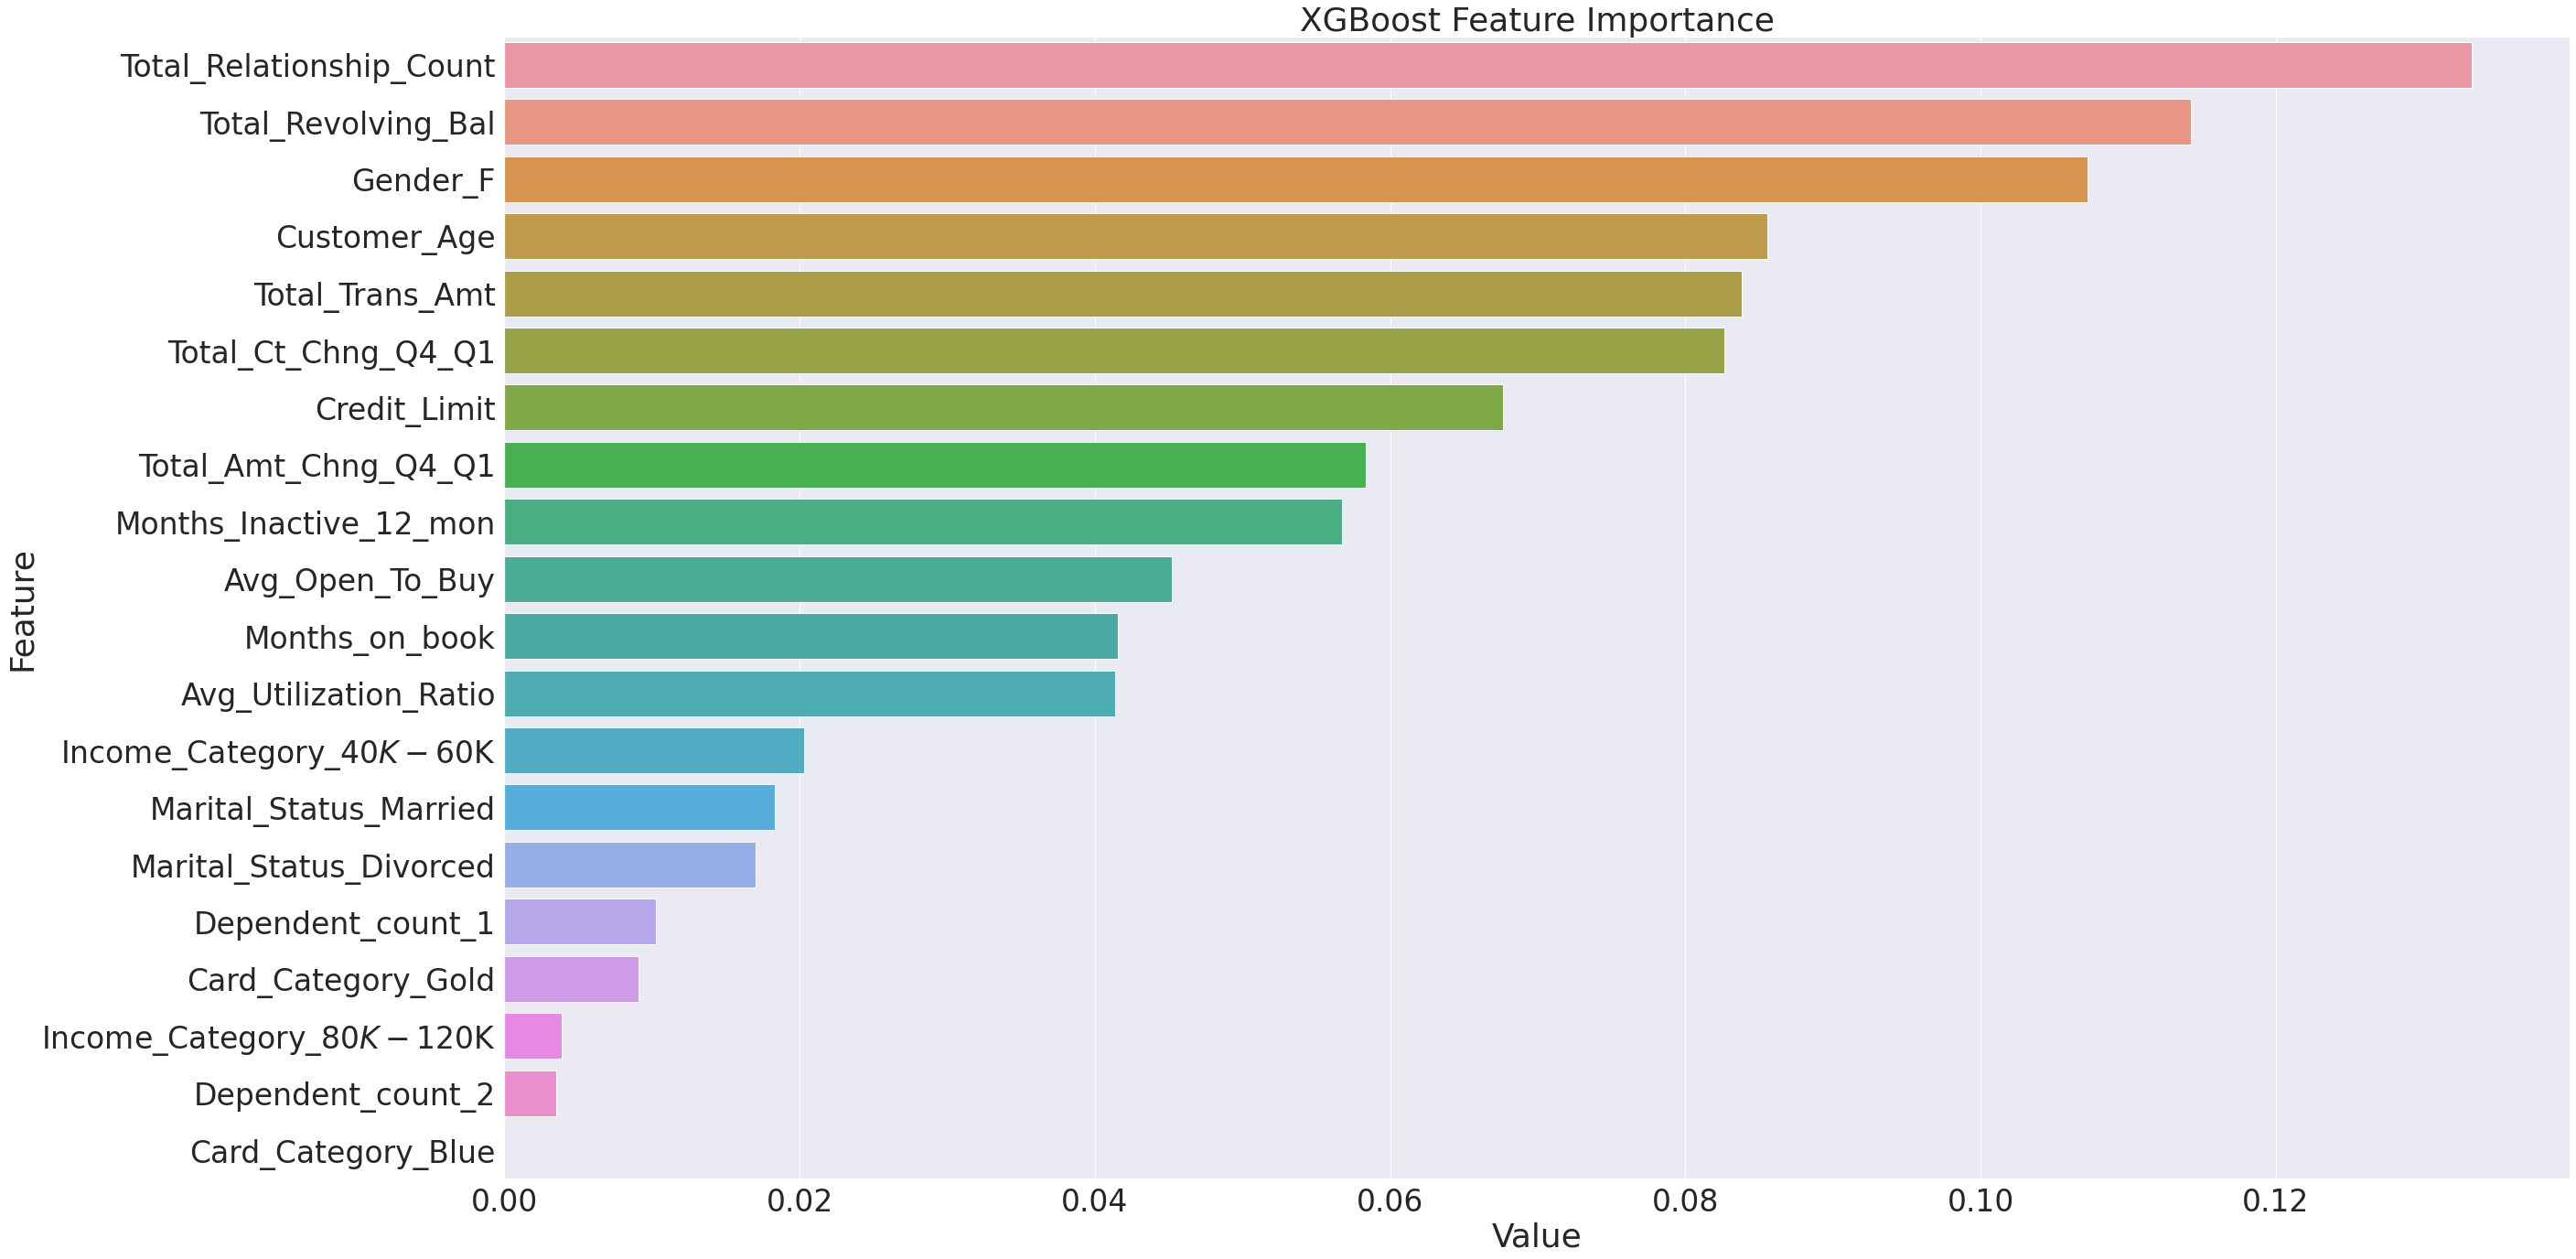

In [31]:
plotImp(model, new_col_names)

In [35]:
joblib.dump(pipeline_xgb, 'model.joblib')

['model.joblib']

In [40]:
job_dir="bucket-aiplatform"

In [37]:
REGION="us-central1 "

In [38]:
!echo $REGION

us-central1


In [41]:
!gsutil cp ./model.joblib gs://$job_dir/model.joblib

Copying file://./model.joblib [Content-Type=application/octet-stream]...
/ [1 files][ 70.9 KiB/ 70.9 KiB]                                                
Operation completed over 1 objects/70.9 KiB.                                     


In [42]:
model = joblib.load("./model.joblib")

In [43]:
instance = ['779031033',46,'F','2','Graduate','Married','$40K - $60K','Blue',22,6,1,3,2305,1627,678,0.747,1230,36,0.565,0.706]
_COLUMN_NAMES=['CLIENTNUM','Customer_Age','Gender','Dependent_count','Education_Level','Marital_Status','Income_Category','Card_Category','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

In [44]:
model.predict(pd.DataFrame(data=[instance], columns=_COLUMN_NAMES))

array(['Existing Customer'], dtype=object)